# 5+n tricks for GANs

The idea behind GANs is to train an implicit model that can produce samples $x' \sim p_g$ that looks like samples taken from the actual data distribution $x \sim p_{data}$ by always trying to fool a discriminator which attempts to differentiate between real and generated samples. The generator and the discriminator are then trained jointly by playing the following min-max game.

$$
\min_{G} \max_{D} \mathbb{E}_{x \sim q_{data}}[\log D(x)] +\mathbb{E}_{x \sim p_g}[\log(1- D(x))] 
$$

However, it might not be practical to compute the following min-max game to see this consider a fixed generator, the above min-max game becomes the following optimisation problem

$$\max_{D} \mathbb{E}_{x \sim q_{data}}[\log D(x)] +\mathbb{E}_{x \sim p_g}[\log(1- D(x))] $$

it can be shown that the optimal discriminator is 

$$D_g^*(x)= \frac{p_{g}(x)}{p_{g}(x)+p_{data}(x)}$$

and the derivative of our discriminator $D(x)$   is 

$$\nabla D^*_g(x) = \frac{1}{p_{data}(x)}\nabla_xp_{data}(x) - \frac{1}{p_g(x)}\nabla_xp_g(x)$$

If $p_g$ and $p_{data}$ do not share the same support, the derivative of our discriminator $D(x)$ becomes unbounded and thus ill-defined. This means we cannot use gradient descent in such a case to find the equilibrium point of our min-max game. However, for datasets that lies on some lower-dimensional manifold, such as natural images, this is often the case because the manifold will only overlap with a distribution $p_g(x)$, where $p_g(x)$ has non-zero measure everywhere, on the manifold. This tutorial thus outlines some basic techniques that can address this and other issues surrounding GAN training. 

## 1. Instance noise to address the problem of disjoint support

From: [Sønderby, C. K., Caballero, J., Theis, L., Shi, W., & Huszár, F. (2016). Amortised map inference for image super-resolution. arXiv preprint arXiv:1610.04490](https://arxiv.org/pdf/1610.04490.pdf)

One simple approach to addressing the disjoint support problem is to apply some instance noise to both the real and fake samples. The noise term can further be reduced/annealed over time to improve performance.

```
real = real + alpha*torch.randn_like(real)
fake = fake + alpha*torch.randn_like(fake)
```

## 2. Use Spectral Normalisation

From: [Miyato, T., Kataoka, T., Koyama, M., & Yoshida, Y. (2018). Spectral normalization for generative adversarial networks. arXiv preprint arXiv:1802.05957.](https://arxiv.org/pdf/1802.05957.pdf)

Another approach of addressing the issue of non-computable or intractable statistics a GAN might provide is to add regularity conditions such as Lipschitz continuity on the discriminator, one way of doing this is to use spectral normalisations, which use power iteration to ensure that the discriminator is Lipschitz continuous by normalising the weight matrix of the neural network by its largest singular value.

$$
W_{SN} = \frac{W}{\sigma(W)}, \text{where } \sigma(W) = \frac{||Wh||_2}{||h||_2}$$

```
from torch import nn
from torch.nn.utils.parametrizations import spectral_norm
m = spectral_norm(nn.Linear(20, 40)) 
```

## 3. Use refinement techniques to incorporate discriminator information post-training

From : [Azadi, S., Olsson, C., Darrell, T., Goodfellow, I., & Odena, A. (2018). Discriminator rejection sampling. arXiv preprint arXiv:1810.06758.](https://arxiv.org/pdf/1810.06758)

One simple approach to improving the quality of samples from a GAN is to use the truncation trick which samples from a truncated normal distribution instead of a normal distribution to avoid sampling at the tails reducing the chance of sampling from regions that lead to poorer sample quality however also reduces the diversity of the samples attained.

```
from scipy.stats import truncnorm
threshold = 1
values = truncnorm.rvs(-threshold, threshold, size=(64, 100))
```

A more principled approach is to use the discriminator to perform rejection sampling using the discriminator but that is too expensive. A better approach is to use discriminator driven latent sampling [DDLS](https://arxiv.org/pdf/2003.06060) or discriminator gradient flow [DGFlow](https://arxiv.org/abs/2012.00780) that uses Langevin sampling to sample from the discriminator. 

```
def _velocity(z_img, D, G):
    z_img_t = z_img.clone()
    z_img_t.requires_grad_(True)
    if z_img_t.grad is not None:
      z_img_t.grad.zero_()
    d_score = D(G(z_img_t)) 
    d_score.backward(torch.ones_like(d_score).to(z_img.device))
    return z_img_t.grad.data

def refine_samples(z_img, G, D, eta=.01, noise_factor=0.,
                   num_steps=200):
    for t in tqdm(range(1, num_steps)):
        v = _velocity(z_img, D, G)
        z_img = z_img.data + eta * v + np.sqrt(2*eta) * noise_factor * torch.randn_like(z_img)
    return G(z_img), z_img
```

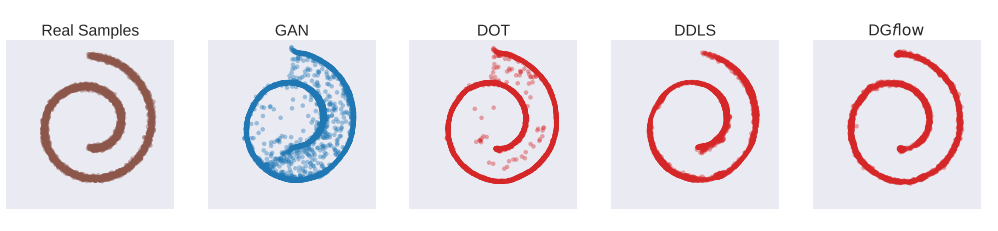

## 4. Consider using latent optimisation to incorporate discriminator information during training

From : [Wu, Y., Donahue, J., Balduzzi, D., Simonyan, K., & Lillicrap, T. (2019). Logan: Latent optimisation for generative adversarial networks. arXiv preprint arXiv:1912.00953.](https://arxiv.org/pdf/1912.00953.pdf)

Another way of incorporating the discriminator is to sample in the gradient direction rather than from random samples $z \sim p(z)$  from the prior. This can be done by first sampling a random $z$  and then computing $\nabla_z D(G(z))$  and taking one gradient step in that direction generated as such

```
noise = noise.view(*noise.shape, 1, 1)
d_score = D(G(noise)) 
d_score.backward(torch.ones_like(d_score).to(noise.device))
noise = noise + alpha*d_score.grad.data
```

This results in better samples and more stable GAN training as it adds a symplectic gradient adjustment into the optimisation procedure, reducing the negative effects of cycling.

## 5. Top-k samples for discriminator training to incorporate discriminator information during training

From: [Sinha, S., Zhao, Z., Goyal, A., Raffel, C., & Odena, A. (2020). Top-k training of gans: Improving gan performance by throwing away bad samples. arXiv preprint arXiv:2002.06224.](https://arxiv.org/pdf/2002.06224.pdf)

The discriminator can also be used during training to take the top_k samples identified by the discriminator during training to compute the loss for the generator. This is because the bottom k-samples produce misleading updates, that point away from the data manifold.

```
topk_predictions = torch.topk( predictions, k )
```

The value of k is annealed through the training process, as the gan gets better and the discriminator gets more informative we can increase the value of k.